In [1]:
%pylab inline

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


##### датасет для задачи регрессии Boston Housing, 

##### необходимо предсказать стоимость дома по 13 признакам.

In [2]:
data = datasets.load_boston()
df = pd.DataFrame(data.data)
df.columns = data.feature_names
y = data.target

In [3]:
print(data.DESCR[:1500])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

____________

##### 1. Исследовать данные. (1 балл)

нарисовать 13 картинок, которые покажут зависимость целевой переменной (таргета, игрека, y) от каждого из признаков.

Hint. используйте https://matplotlib.org/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

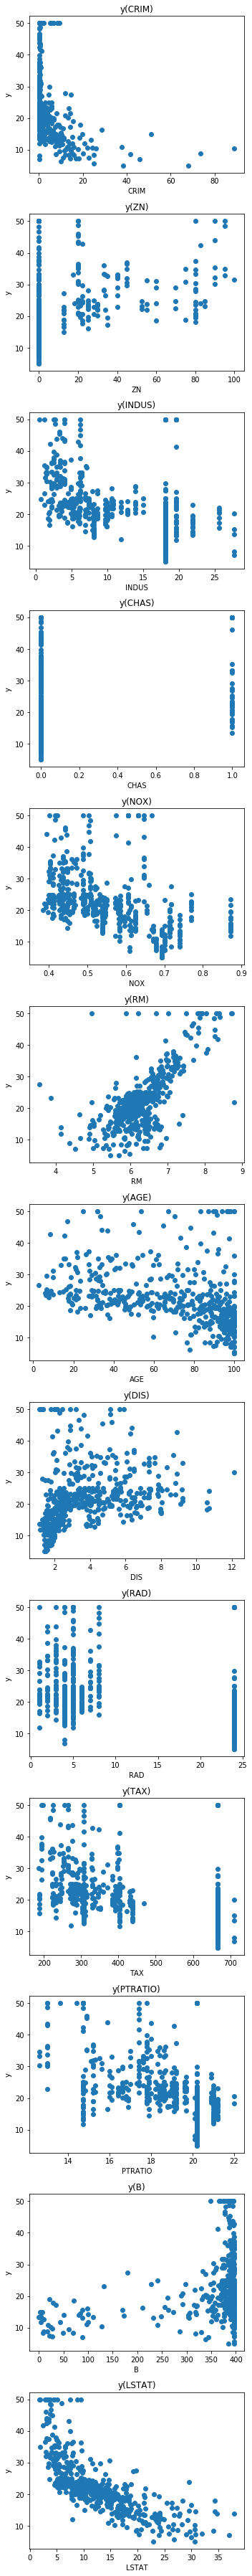

In [4]:
fig, axes = plt.subplots(nrows=13, ncols=1, figsize=(5, 50))

for i in range(df.values.shape[1]):
    axes[i].scatter(df.values[:, i], y)
    axes[i].set_title(f"y({df.columns[i]})")
    axes[i].set_xlabel(df.columns[i])
    axes[i].set_ylabel('y')
    
fig.tight_layout()

##### 2. Обучить регрессию. (1 балл)

Обучите любую линейную регрессию из sklearn. Померить качество на тестовой части по метрикам RMSE, R2.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.values, y, test_size=0.2, random_state=42)
# не меняйте рандом стейт! - он поможет сделать вычисления воспроизводимыми

In [6]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [7]:
print('MSE: %.4f\nR2: %.4f' % (np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)))

MSE: 4.9286
R2: 0.6688


##### 3. Сделайте крутую фичу. (1 балл)

Вернитесь к скатерплотам. Если вы правильно все построили - то вы увидите что один из признаков (LSTAT) как то зависит от y. Сделайте спрямляющее преобразование (добавьте новый признак) и обучите регрессию и померийте снова качество по метрикам RMSE, R2. если все сделали правильно, то кажется что оно должно вырасти

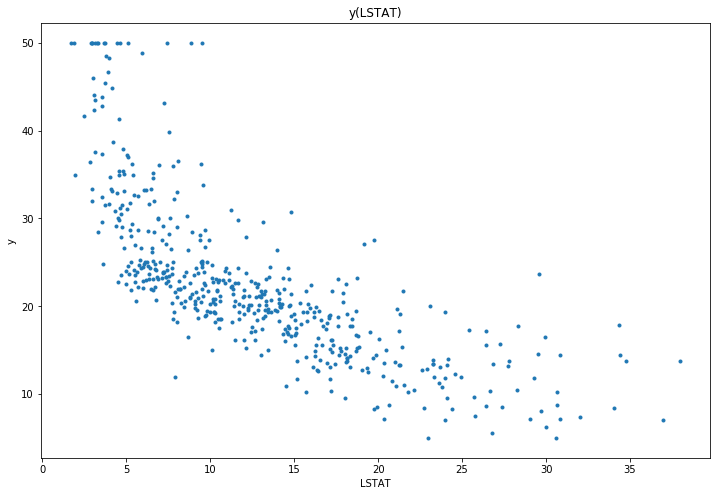

In [8]:
plt.figure(figsize=(12,8))

plt.scatter(df.values[:, -1], y, marker='.');
plt.title(f"y({df.columns[-1]})");
plt.xlabel(df.columns[-1]);
plt.ylabel('y');

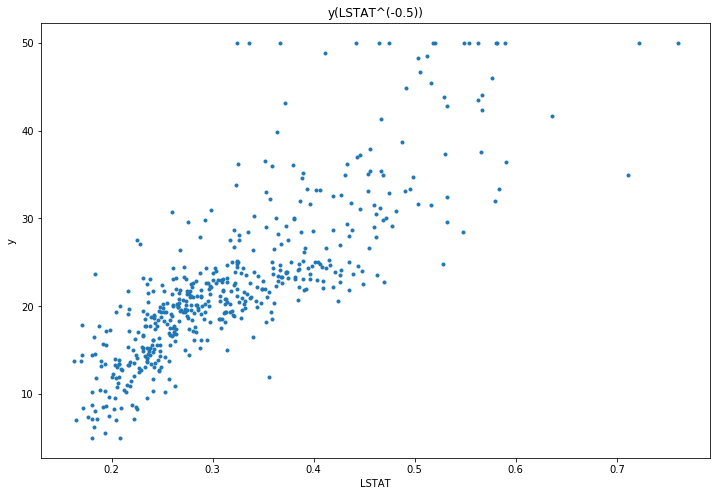

In [9]:
newfeature = df.values[:, -1] ** (-1/2)
newx = np.hstack([df.values, newfeature.reshape(newfeature.shape[0], 1)])

plt.figure(figsize=(12,8))

plt.scatter(newfeature, y, marker='.');
plt.title(f"y({df.columns[-1]}^(-0.5))");
plt.xlabel(df.columns[-1]);
plt.ylabel('y');

In [10]:
X_train, X_test, y_train, y_test = train_test_split(newx, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('MSE: %.4f\nR2: %.4f' % (np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)))

MSE: 4.2619
R2: 0.7523


> добейтесь качества по R2

- 0.751


##### 4. задание про кросс-валидацию 

выберите оптимальный параметр регуляризации на ridge с помощью кросс-валидации на трейне. померийте качество на тесте. Увеличелось ли оно на метриках?

In [11]:
cv = KFold(n_splits=5)
params = {
    'alpha': np.power(10., np.arange(-6, 6)),
    'tol': np.power(10., np.arange(-6, -1))
}

rr = Ridge(random_state=42)
gs = GridSearchCV(rr, param_grid=params, scoring='r2', cv=cv, n_jobs=-1 )
gs.fit(X_train, y_train)
print('Best score:', gs.best_score_.round(4))
print('Best params:', gs.best_params_)

Best score: 0.776
Best params: {'alpha': 0.1, 'tol': 1e-06}


In [12]:
y_pred = gs.predict(X_test)
print('MSE: %.4f\nR2: %.4f' % (np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)))

MSE: 4.2993
R2: 0.7480


#### Качество не выросло :(

##### 5. задание про пайплайн

Используйте Pipeline из пакета sklearn.
сделайте поиск по параметрам (GridSearch), автоматически выберете какой способ нормировки признаков (минмакс скейлинг, стандарт скейлер) работает лучше, добавьте полиномиальных признаков, автоматически выберите модель (ридж лассо или просто регрессия) и регуляризацию к ней (если нужно).

In [13]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('poly', PolynomialFeatures(include_bias=False)),
                     ('regressor', LinearRegression(n_jobs=-1)),
                    ])


In [14]:
param_grid = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [LinearRegression(n_jobs=-1)]
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [Ridge(), Lasso()],
        'regressor__alpha': np.power(10.,np.arange(-3, 3)) 
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'poly__degree': list(range(1,5)),
        'regressor': [ElasticNet()],
        'regressor__alpha': np.power(10.,np.arange(-3, 3)),
        'regressor__l1_ratio': np.power(10.,np.arange(-3, 3)) 
    },
]

> добейтесь качества по R2

- 0.811


In [15]:
gscv = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1)
gscv.fit(X_train, y_train)

print('Best score:', gscv.best_score_.round(4))
print('Best params:', gscv.best_params_)

Best score: 0.8747
Best params: {'poly__degree': 3, 'regressor': ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.1, 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}


In [17]:
preds = gscv.predict(X_test)
print('MSE: %.4f\nR2: %.4f' % (np.sqrt(mean_squared_error(y_test, preds)), r2_score(y_test, preds)))

MSE: 3.3133
R2: 0.8503
